# Aperiodic component analysis

This script loads the parameter estimates from the aperiodic component analysis from IRASA and FOOOF, and plots the results.

In [17]:
%matplotlib inline

## Import packages 
#import yasa
import pingouin as pg
import pickle
from fooof import FOOOF
from fooof.objs.utils import average_fg, combine_fooofs, compare_info
from fooof.bands import Bands
import numpy as np
import os
import mne
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal 
import scipy.stats as stats
mne.set_log_level('WARNING')

# Set plotting settings
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('colorblind')

# Set paths
fig_path = '/mnt/server/data03/2023_NENA_Aperiodic_Workshop/figures/group/'

## 1. Load aperiodic component data

In [18]:
# Load data
df = pd.read_csv('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/results/aperiodic.csv')
# Check unique values in 'Stage' for each subject and filter subjects
df = df.groupby('Subject').filter(lambda x: set(x['Stage']) == {0.0, 1.0, 2.0, 3.0, 4.0})
# Reset index
df.reset_index(drop=True, inplace=True)
# Print means
df.groupby(['Method', 'Stage'])[['Slope', 'Intercept','R^2', 'std(osc)']].mean()

Slope  Intercept       R^2  std(osc)
Method Stage                                         
FOOOF  0.0    1.296922   1.446380  0.984107  0.118236
       1.0    1.795441   1.575595  0.993779  0.167600
       2.0    2.188888   2.003597  0.993250  0.213843
       3.0    2.743597   2.760291  0.997553  0.181911
       4.0    2.011220   1.702577  0.989760  0.209324
IRASA  0.0    1.408779   1.634665  0.916122  0.384672
       1.0    1.986826   1.936033  0.931139  0.687072
       2.0    2.456018   2.460759  0.944655  1.572071
       3.0    2.975146   3.126499  0.978031  3.693241
       4.0    2.238393   2.142718  0.928632  1.531000

## 2. Plot aperiodic component parameters

In [19]:
# Pivot data for correlations
df_pivot = df.pivot_table(index=['Subject', 'Chan', 'Stage'], columns='Method')
df_pivot

Intercept                 R^2               Slope  \
Method                 FOOOF     IRASA     FOOOF     IRASA     FOOOF   
Subject Chan Stage                                                     
800010  C3   0.0    1.442243  1.759500  0.993319  0.865991  1.181327   
             1.0    1.628949  1.953569  0.990978  0.891931  1.792028   
             2.0    2.163489  2.560140  0.994314  0.939030  2.184440   
             3.0    2.956931  3.384353  0.996225  0.957914  2.762550   
             4.0    1.783549  2.137405  0.989107  0.904527  1.890820   
...                      ...       ...       ...       ...       ...   
802739  C4   0.0    1.290484  1.442966  0.997387  0.964523  1.320375   
             1.0    1.866445  2.038462  0.998342  0.982012  2.076999   
             2.0    1.905306  2.168996  0.997980  0.976162  2.156738   
             3.0    2.502161  2.812063  0.993477  0.994424  2.600625   
             4.0    1.754594  2.129290  0.996527  0.947505  2.120951   

                              std(osc)            
Method                 IRASA     FOOOF     IRASA  
Subject Chan Stage                                
800010  C3   0.0    1.296392  0.191427  0.599698  
             1.0    1.842014  0.250363  0.220546  
             2.0    2.346661  0.232976  0.463507  
             3.0    2.992645  0.269896  3.363164  
             4.0    1.963364  0.251570  0.324347  
...                      ...       ...       ...  
802739  C4   0.0    1.395471  0.104231  0.140712  
             1.0    2.152169  0.110698  0.579400  
             2.0    2.286616  0.135930  0.224162  
             3.0    2.816422  0.128468  4.245141  
             4.0    2.281142  0.204397  0.166016  

[580 rows x 8 columns]

### 2a. Plot parameter correlations & distribution between IRASA and FOOOF 

Correlation between IRASA and FOOOF for Intercept: 0.9674
T-test between IRASA and FOOOF for Intercept: t(579) = -56.01, p = 6.42e-236
Correlation between IRASA and FOOOF for Slope: 0.9788
T-test between IRASA and FOOOF for Slope: t(579) = -40.80, p = 1.86e-172
Correlation between IRASA and FOOOF for R^2: 0.3142
T-test between IRASA and FOOOF for R^2: t(579) = 23.70, p = 2.63e-87
Correlation between IRASA and FOOOF for std(osc): 0.2984
T-test between IRASA and FOOOF for std(osc): t(579) = -3.72, p = 2.18e-04


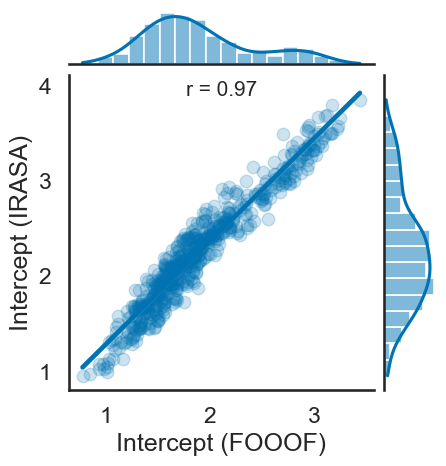

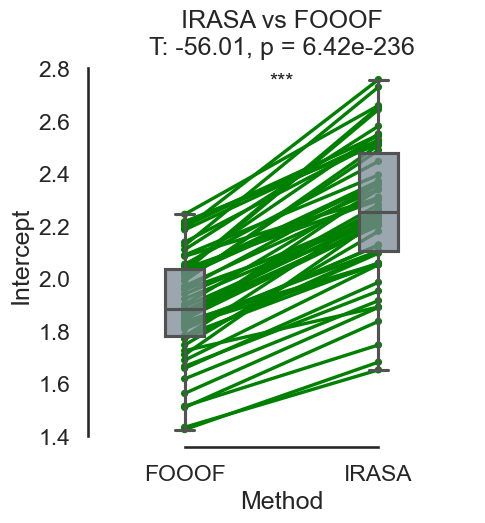

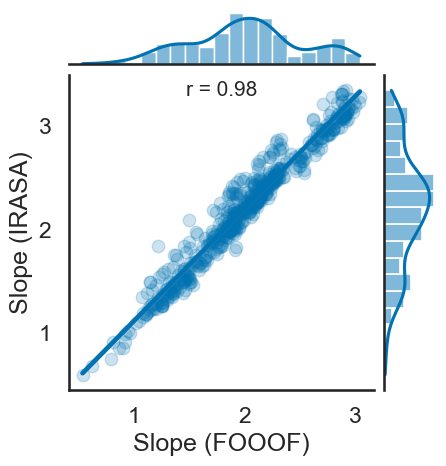

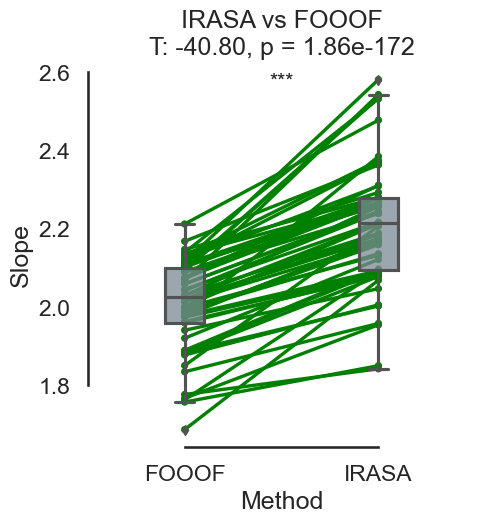

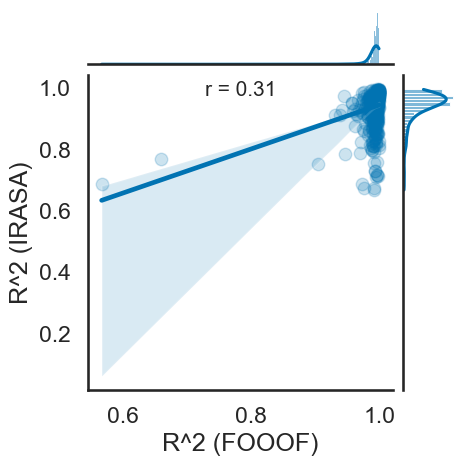

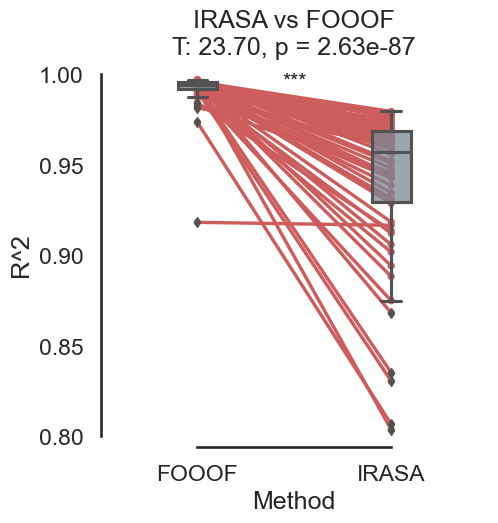

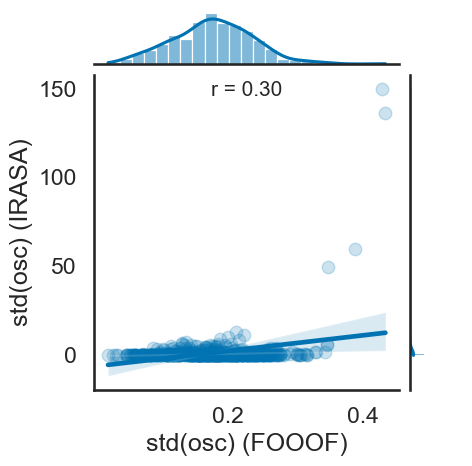

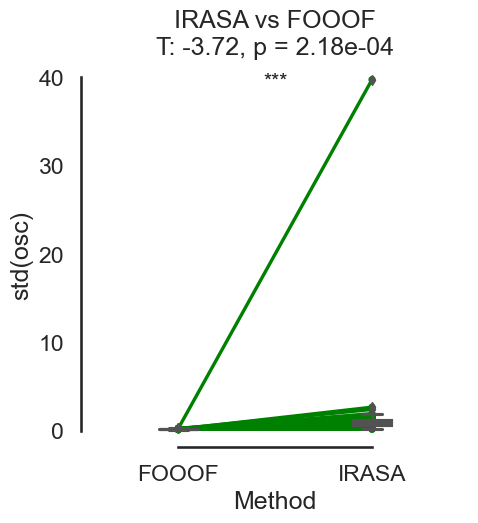

In [20]:
# Plot distributions with correlations
# Loop over each parameter
for param in ['Intercept', 'Slope', 'R^2', 'std(osc)']:
    # Compute and print correlation
    corr = df_pivot[(param, 'FOOOF')].corr(df_pivot[(param, 'IRASA')], method='pearson')
    print(f'Correlation between IRASA and FOOOF for {param}: {corr.round(4)}')

    # Jointplot with regression line and distribution plots
    ax1 = sns.jointplot(data=df_pivot, x=(f'{param}', 'FOOOF'), y=(f'{param}', 'IRASA'), 
                        kind="reg", scatter_kws={'alpha': 0.2}, palette='colorblind', height=5
                        )
    # Setting x and y labels without '' and ()
    ax1.ax_joint.set_xlabel(f'{param} (FOOOF)')
    ax1.ax_joint.set_ylabel(f'{param} (IRASA)')
    ax1.ax_joint.text(0.5, .95, f'r = {corr:.2f}', ha='center', va='center', 
                      transform=ax1.ax_joint.transAxes, fontsize=15)
    plt.savefig(f'{fig_path}{param}_distribution.png')

    # KDE distribution plots
    #fig1, ax1 = plt.subplots(figsize=(10, 5))
    #sns.kdeplot(data=df, x=param, hue='Method', fill=True, alpha=0.5, ax=ax1)
    #ax1.set_title(f'{param} Distribution')
    #ax1.set_ylabel('Density')
    #plt.savefig(f'{fig_path}{param}_distribution.png')

    # Compute paired t-test
    t_stat, p_val = stats.ttest_rel(df_pivot[(param, 'FOOOF')], df_pivot[(param, 'IRASA')])
    print(f'T-test between IRASA and FOOOF for {param}: t({len(df_pivot) - 1}) = {t_stat:.2f}, p = {p_val:.2e}')

    # Paired plot visualization
    fig2, ax2 = plt.subplots(figsize=(5, 5))
    pg.plot_paired(data=df, dv=param, within='Method', subject='Subject', boxplot_in_front=True, ax=ax2)
    ax2.set_title(f'IRASA vs FOOOF\nT: {t_stat:.2f}, p = {p_val:.2e}')

    # Determine significance level and annotate the plot
    if p_val < 0.001:
        significance = '***'
    elif p_val < 0.01:
        significance = '**'
    elif p_val < 0.05:
        significance = '*'
    else:
        significance = 'n.s.'
    plt.text(0.5, .95, significance, ha='center', va='center', 
             transform=ax2.transAxes, fontsize=15)
    plt.savefig(f'{fig_path}{param}_ttest.png')

### 2b. Plot aperiodic component distribution between IRASA and FOOOF across sleep stages

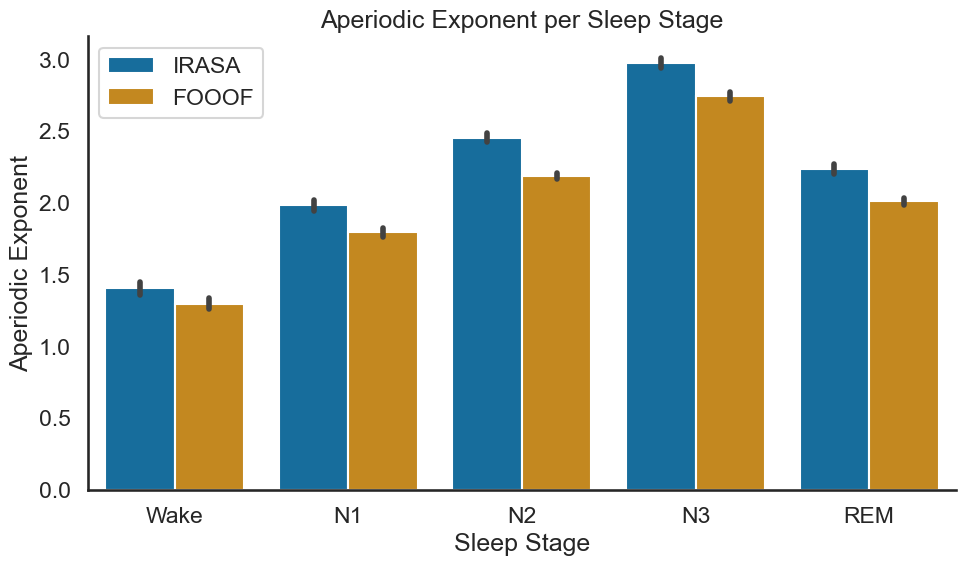

In [21]:
# Plot the aperiodic exponent for each sleep stage
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df, x='Stage', y='Slope', hue='Method', ax=ax)
#sns.swarmplot(data=df, x='Stage', y='Slope', hue='Method', dodge=True, ax=ax)
ax.set_xlabel('Sleep Stage')
ax.set_xticklabels(['Wake', 'N1', 'N2', 'N3', 'REM'])
ax.set_ylabel('Aperiodic Exponent')
ax.set_title('Aperiodic Exponent per Sleep Stage')
ax.legend(loc='upper left')
sns.despine()
plt.tight_layout()
plt.savefig(f'{fig_path}Slope_stage.png')

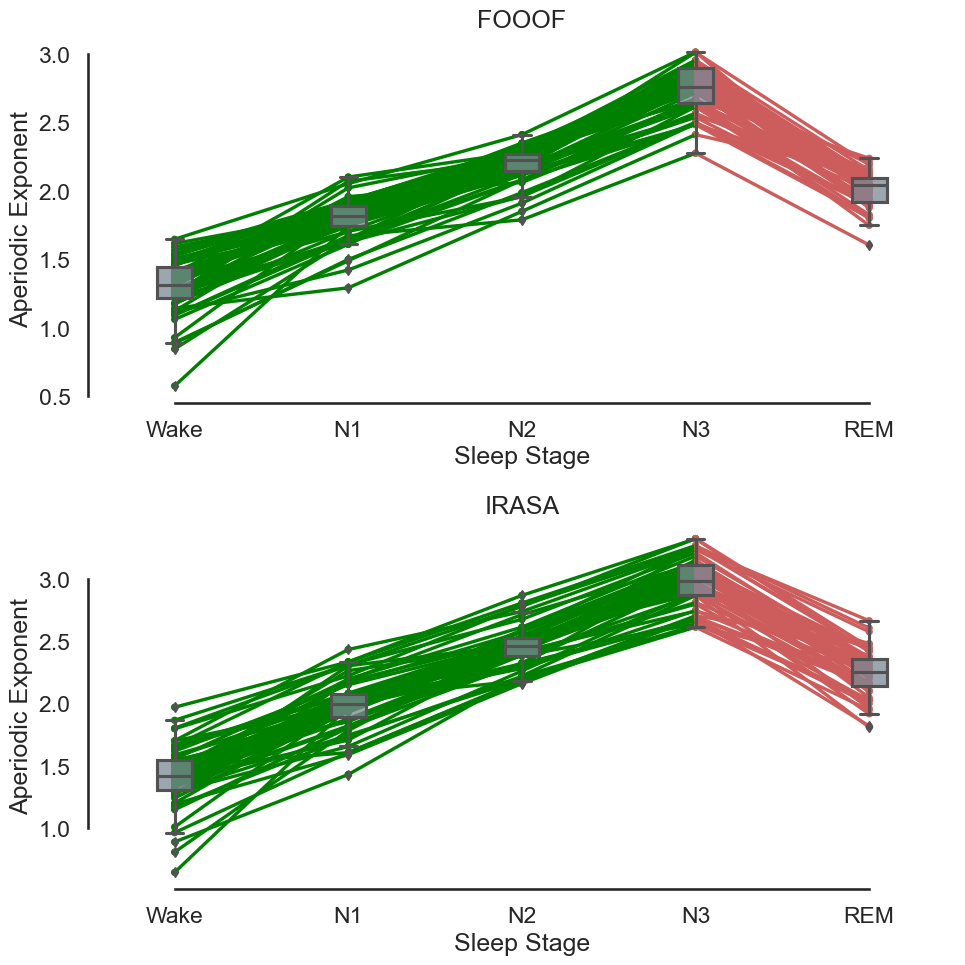

In [22]:
# Paired to show subject level similarity in stagewise aperiodic exponent 
fig3, ax3 = plt.subplots(2, 1, figsize=(10, 10))
pg.plot_paired(data=df[df['Method'] == 'FOOOF'], dv='Slope', within='Stage',
               subject='Subject', orient='v', ax=ax3[0], boxplot_in_front=True)
ax3[0].set_title('FOOOF')
ax3[0].set_ylabel('Aperiodic Exponent')
ax3[0].set_xticklabels(['Wake', 'N1', 'N2', 'N3', 'REM'])
ax3[0].set_xlabel('Sleep Stage')

pg.plot_paired(data=df[df['Method'] == 'IRASA'], dv='Slope', within='Stage',
               subject='Subject', orient='v', ax=ax3[1], boxplot_in_front=True)
ax3[1].set_title('IRASA')
ax3[1].set_ylabel('Aperiodic Exponent')
ax3[1].set_xticklabels(['Wake', 'N1', 'N2', 'N3', 'REM'])
ax3[1].set_xlabel('Sleep Stage')

plt.tight_layout()
plt.savefig(f'{fig_path}Slope_paired.png')

### 2c. Repeated measures ANOVA for aperiodic component parameters across sleep stages and methods

In [23]:
# ANOVA for aperiodic exponent x sleep stage x method
aov = pg.rm_anova(data=df, dv='Slope', within=['Stage', 'Method'], subject='Subject')
pg.print_table(aov)


ANOVA SUMMARY

Source               SS    ddof1    ddof2      MS         F    p-unc    p-GG-corr    ng2    eps
--------------  -------  -------  -------  ------  --------  -------  -----------  -----  -----
Stage           142.459        4      228  35.615  1195.278    0.000        0.000  0.886  0.687
Method            6.142        1       57   6.142   255.673    0.000        0.000  0.250  1.000
Stage * Method    0.404        4      228   0.101    78.927    0.000        0.000  0.021  0.786



Both Stage [F(4, 228) = 1195.278, p < 0.001, η² = 0.886] and Method [F(1, 57) = 255.673, p < 0.001, η² = 0.250] exerted significant effects on the outcome. Notably, there was also a significant interaction between Stage and Method [F(4, 228) = 78.927, p < 0.001, η² = 0.021], suggesting that the influence of one variable is contingent upon the level of the other, although the effect size was small.

## 3. Plot final fits with average aperiodic component

In [24]:
# Load pickled FOOOF and IRASA objects
with open('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/results/fooof_groups_dict.pkl', 'rb') as f:
    fooof = pickle.load(f)
with open('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/results/psd_aperiodic_dict.pkl', 'rb') as f:
    irasa_aperiodic = pickle.load(f)
with open('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/results/psd_oscillatory_dict.pkl', 'rb') as f:
    irasa_periodic = pickle.load(f)

### 3a. Plot group spectral fits with IRASA

/tmp/ipykernel_1093744/1037419944.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = np.abs(fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median())
/tmp/ipykernel_1093744/1037419944.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = np.abs(fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median())
/tmp/ipykernel_1093744/1037419944.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = np.abs(fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median())
/tmp/ipykernel_1093744/1037419944.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = np.abs(fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median())
/tmp/ipykernel_1093744/1037419944.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = np.abs(fit_params.set_index(['Chan','Stage']).loc[chan, s

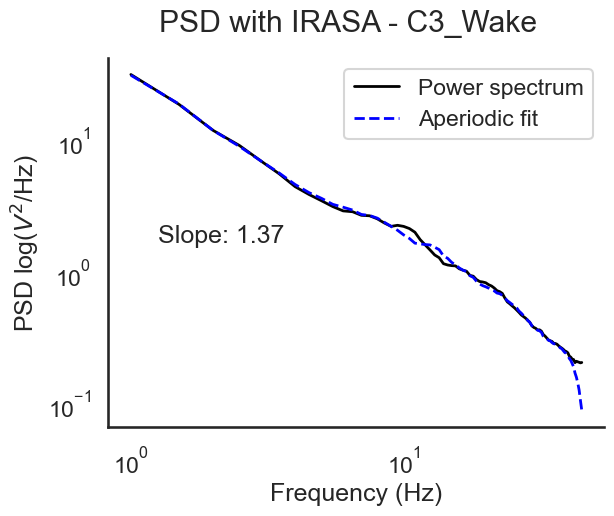

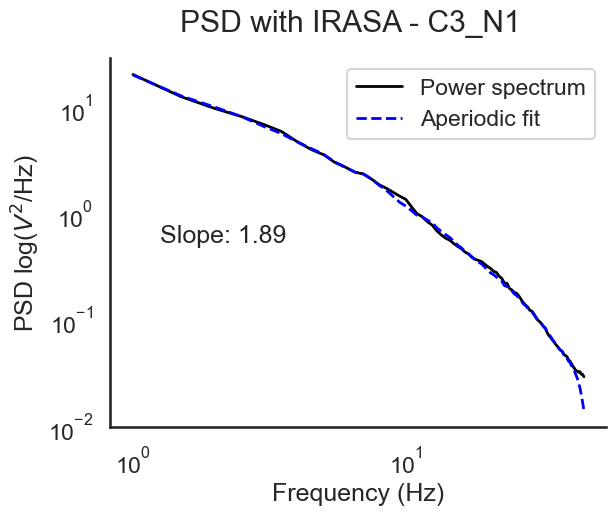

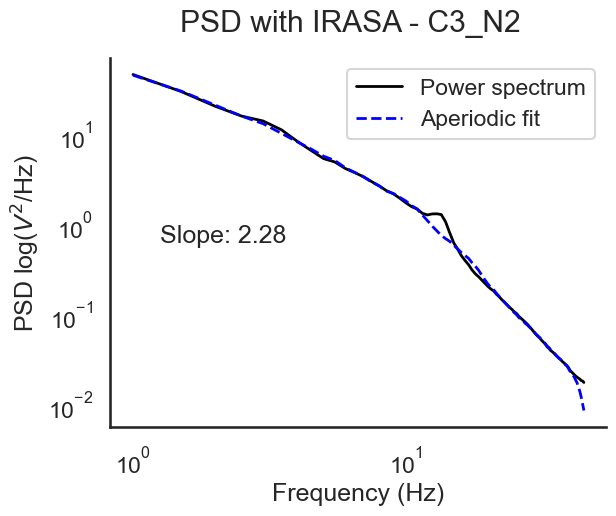

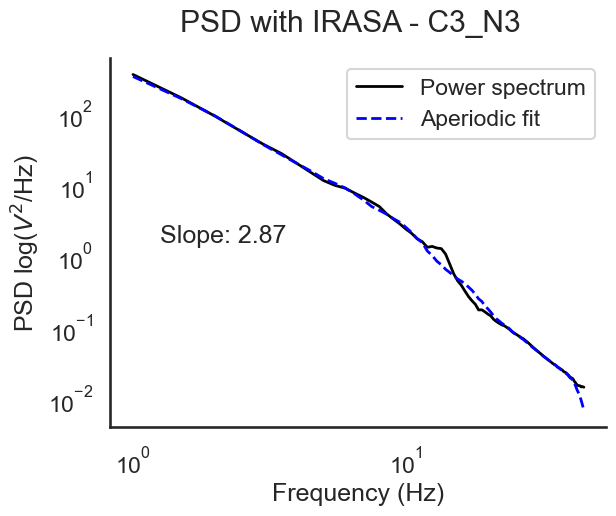

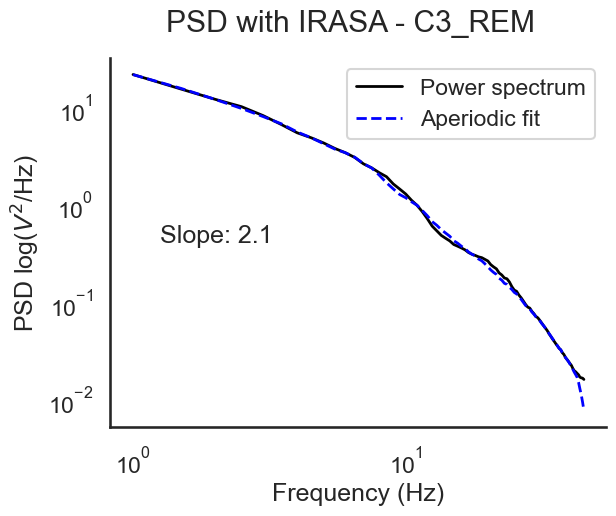

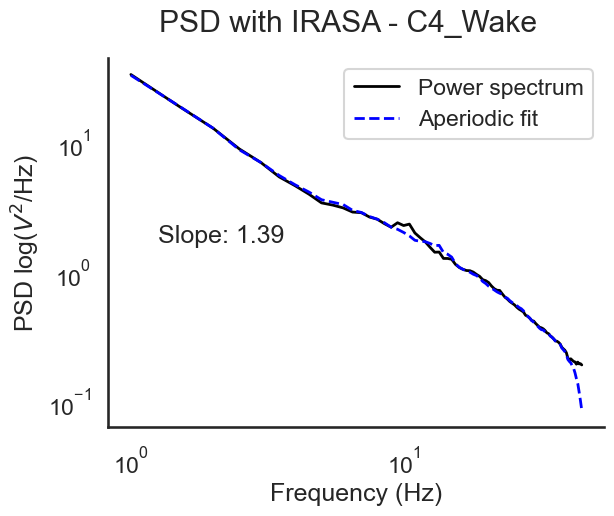

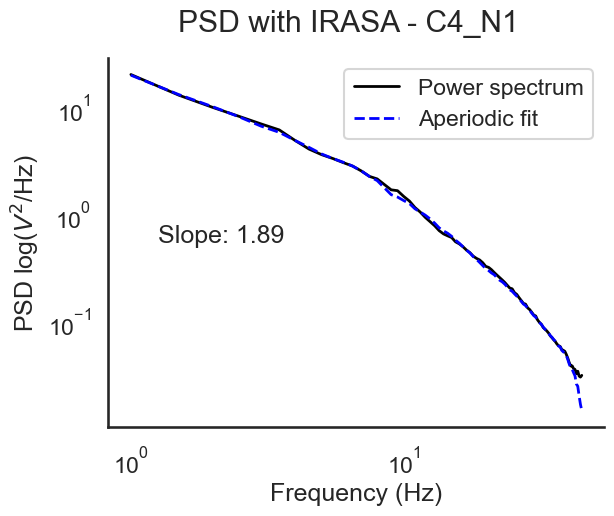

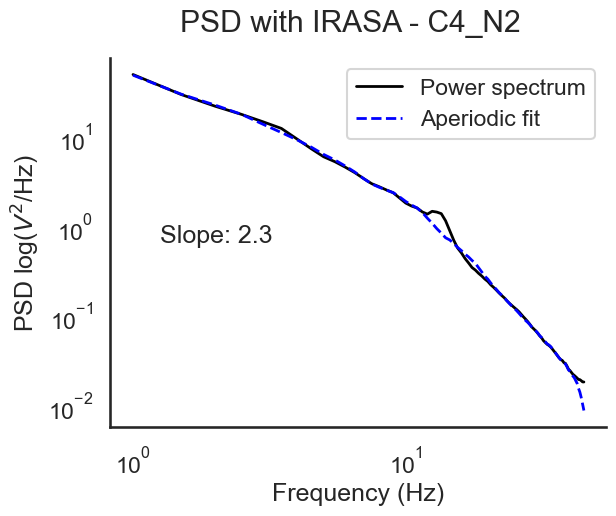

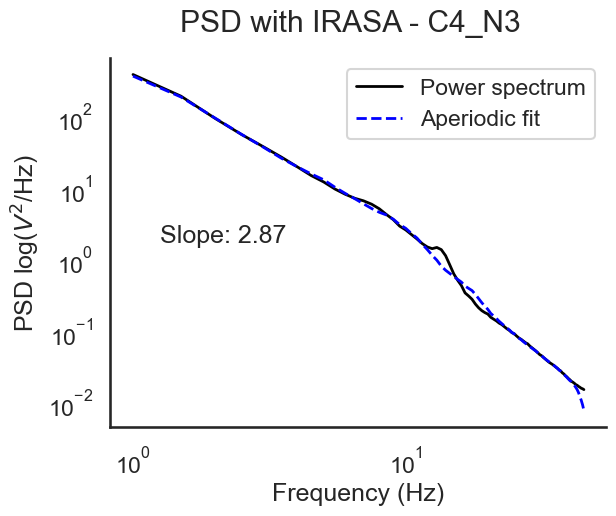

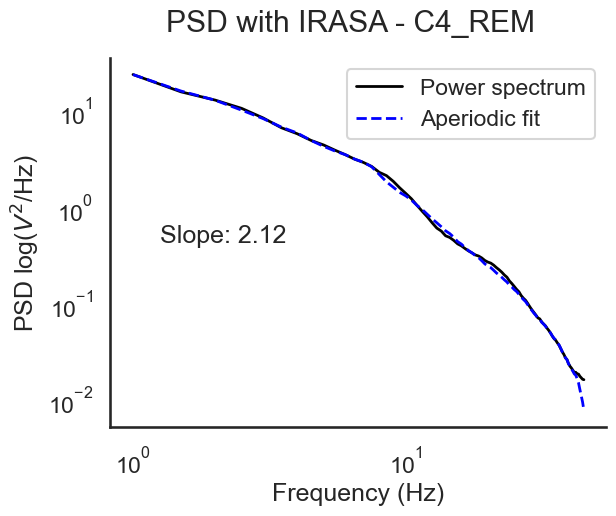

In [25]:
for chan in ['C3', 'C4']:
    for stage, stage_name in zip([0, 1, 2, 3, 4], 
                                 ['Wake', 'N1', 'N2', 'N3', 'REM']):
        
        # Get fit parameters
        fit_params = df.copy()
        freqs = fooof[0][(0.0, 'C3')].freqs #for example

        # Get median PSDs
        psd_ap = np.median(
            [irasa_aperiodic[idx][(stage, chan)] 
             for idx in range(len(irasa_aperiodic))
             if (stage, chan) in irasa_aperiodic[idx]], 
            axis=0
        )

        psd_osc = np.median(
            [irasa_periodic[idx][(stage, chan)] 
             for idx in range(len(irasa_periodic)) 
             if (stage, chan) in irasa_periodic[idx]], 
            axis=0
        )

        # Plot IRASA results
        fig = plt.figure() 
        plt.tight_layout()
        plt.yscale('log')
        plt.xscale('log')
        plt.plot(freqs, (psd_ap+psd_osc).ravel(), c='k', label="Power spectrum", lw=2)
        plt.plot(freqs, psd_ap.ravel(), c='b',linestyle='--', label="Aperiodic fit", lw=2)
        #plt.plot(freqs, psd_osc.ravel(), c='cyan',linestyle='--', label="Periodic components", lw=2)
        fig.suptitle(f'PSD with IRASA - {chan}_{stage_name}')
        fig.axes[0].set_xlabel("Frequency (Hz)")
        fig.axes[0].set_ylabel("PSD log($V^2$/Hz)")
        fig.axes[0].legend()
        # set text with fit parameters 
        slope = np.abs(fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median())
        fig.axes[0].text(0.1, 0.5, f"Slope: {round(slope,2)}",
                        transform=fig.axes[0].transAxes)    
        sns.despine()   
        plt.savefig(f'{fig_path}IRASA_{chan}_{stage_name}.png')

### 3b. Plot group spectral fits with FOOOF

In [26]:
C3_Wake = combine_fooofs([fooof[sub_idx][(0, 'C3')] for sub_idx in range(len(fooof)) if (0, 'C3') in fooof[sub_idx]])
C4_Wake = combine_fooofs([fooof[sub_idx][(0, 'C4')] for sub_idx in range(len(fooof)) if (0, 'C4') in fooof[sub_idx]])
C3_N1 = combine_fooofs([fooof[sub_idx][(1, 'C3')] for sub_idx in range(len(fooof)) if (1, 'C3') in fooof[sub_idx]])
C4_N1 = combine_fooofs([fooof[sub_idx][(1, 'C4')] for sub_idx in range(len(fooof)) if (1, 'C4') in fooof[sub_idx]])
C3_N2 = combine_fooofs([fooof[sub_idx][(2, 'C3')] for sub_idx in range(len(fooof)) if (2, 'C3') in fooof[sub_idx]])
C4_N2 = combine_fooofs([fooof[sub_idx][(2, 'C4')] for sub_idx in range(len(fooof)) if (2, 'C4') in fooof[sub_idx]])
C3_N3 = combine_fooofs([fooof[sub_idx][(3, 'C3')] for sub_idx in range(len(fooof)) if (3, 'C3') in fooof[sub_idx]])
C4_N3 = combine_fooofs([fooof[sub_idx][(3, 'C4')] for sub_idx in range(len(fooof)) if (3, 'C4') in fooof[sub_idx]])
C3_REM = combine_fooofs([fooof[sub_idx][(4, 'C3')] for sub_idx in range(len(fooof)) if (4, 'C3') in fooof[sub_idx]])
C4_REM = combine_fooofs([fooof[sub_idx][(4, 'C4')] for sub_idx in range(len(fooof)) if (4, 'C4') in fooof[sub_idx]])

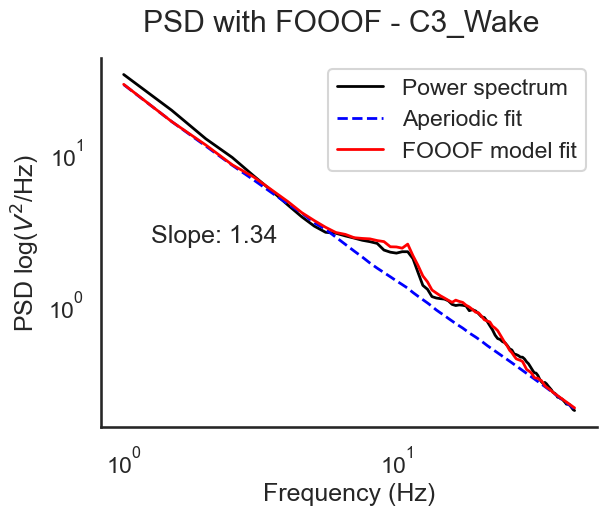

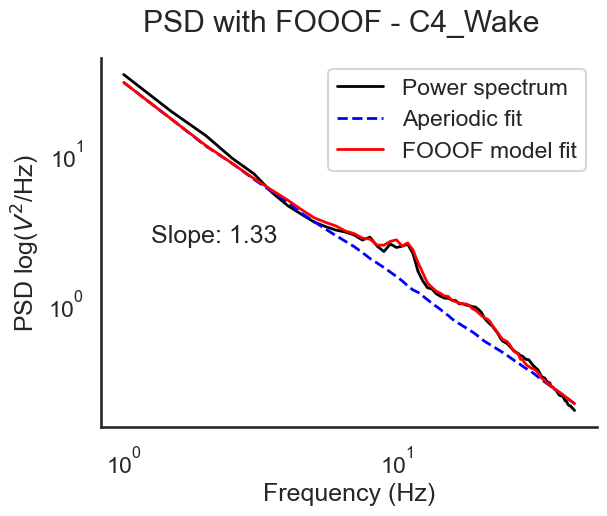

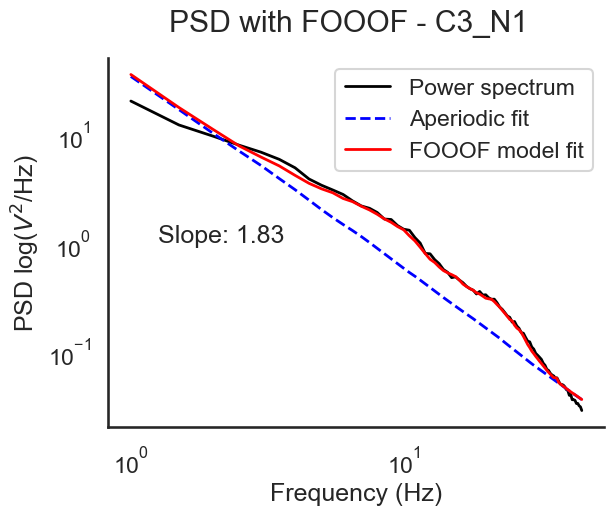

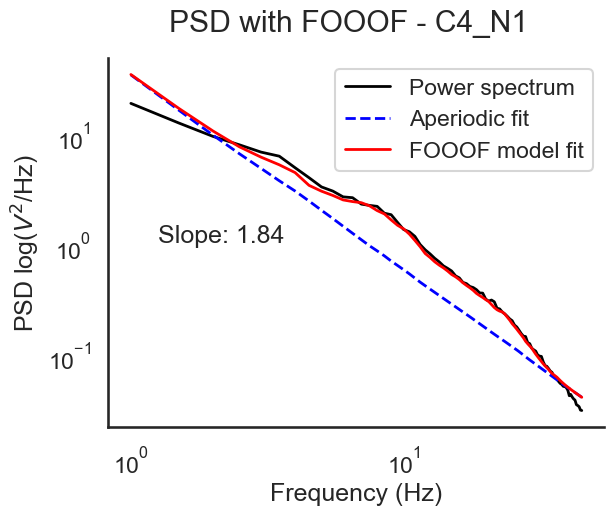

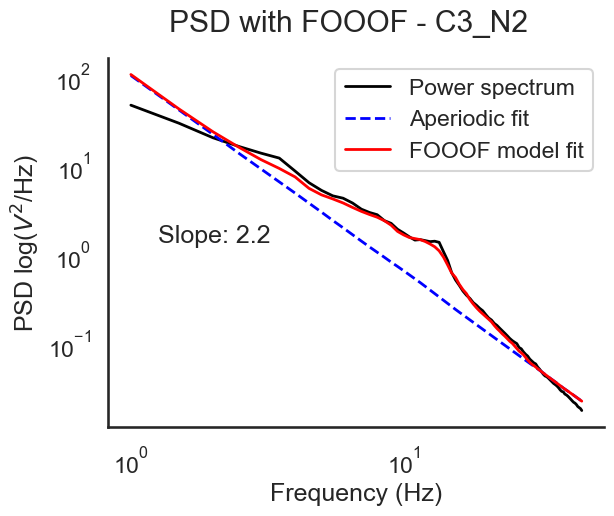

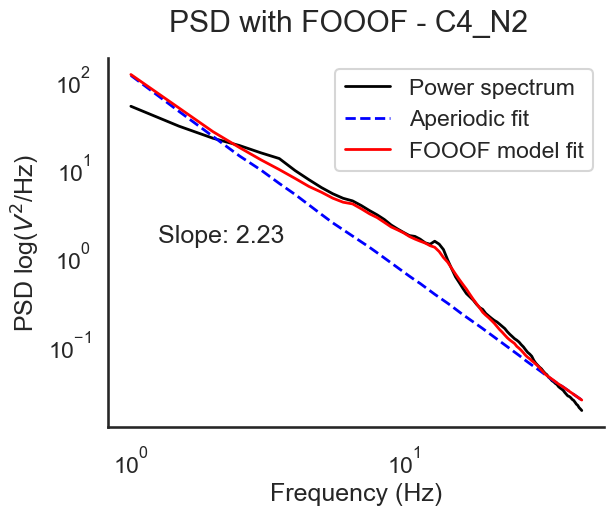

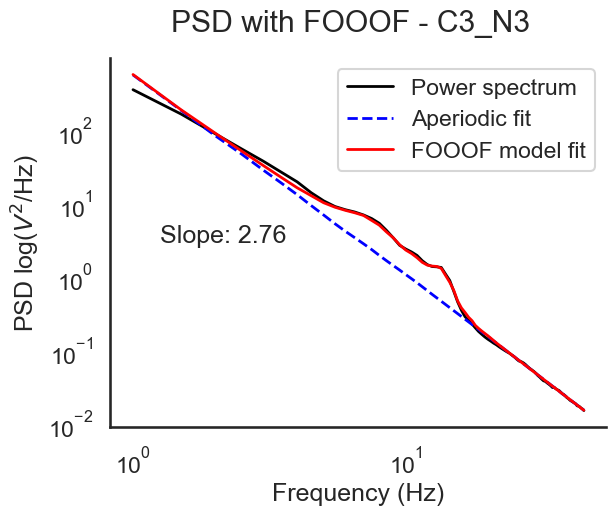

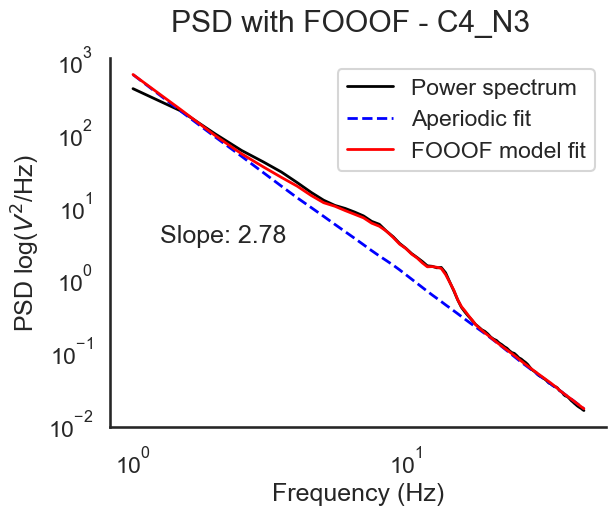

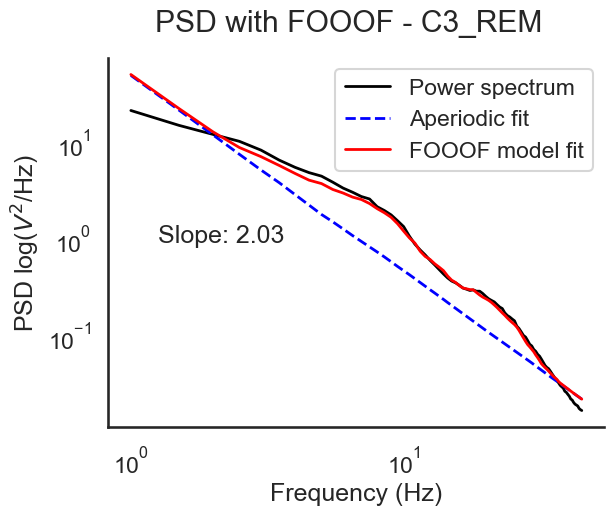

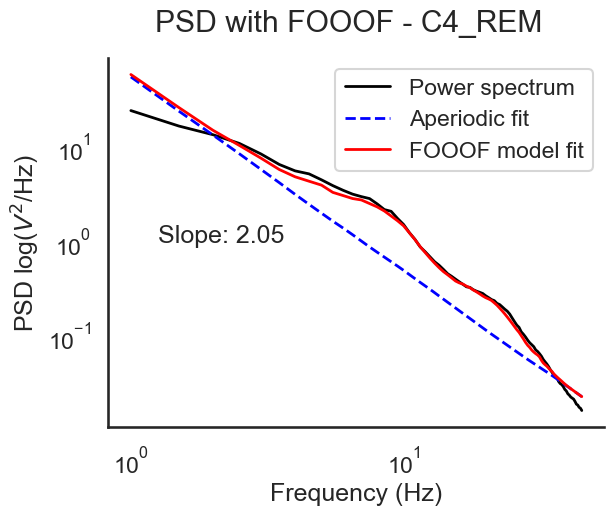

In [27]:
for obj, obj_name in zip([C3_Wake, C4_Wake, C3_N1, C4_N1, C3_N2, C4_N2, C3_N3, C4_N3, C3_REM, C4_REM],
                         ['C3_Wake', 'C4_Wake', 'C3_N1', 'C4_N1', 'C3_N2', 'C4_N2', 'C3_N3', 'C4_N3', 'C3_REM', 'C4_REM']):
    bands = Bands({'Broadband': [1, 45]})
    # Average across individual models fits, specifying bands and an averaging function
    #afm = average_fg(obj, bands, avg_method='median')
    afm_fooofed_spectrum_ = np.median([obj.get_fooof(ind=idx, regenerate=True).fooofed_spectrum_ for idx in range(len(obj))], axis=0)
    afm_ap_fit = np.median([obj.get_fooof(ind=idx, regenerate=True)._ap_fit for idx in range(len(obj))], axis=0)
    aperiodic = np.median([obj.get_fooof(ind=idx, regenerate=True).aperiodic_params_[1] for idx in range(len(obj))])
    # Plot FOOOF results
    fig = plt.figure() 
    plt.tight_layout()
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(obj.freqs, 10**(np.median(obj.power_spectra, 0)), c='k', label="Power spectrum", lw=2)
    plt.plot(obj.freqs, 10**(afm_ap_fit), c='b',linestyle='--', label="Aperiodic fit", lw=2)
    plt.plot(obj.freqs, 10**(afm_fooofed_spectrum_), c='r', label="FOOOF model fit", lw=2)
    fig.suptitle(f'PSD with FOOOF - {obj_name}')
    fig.axes[0].set_xlabel("Frequency (Hz)")
    fig.axes[0].set_ylabel("PSD log($V^2$/Hz)")
    fig.axes[0].legend()
    # set text with fit parameters
    #fig.axes[0].text(0.1, 0.5, f"Slope: {round(obj.aperiodic_params_[1], 2)}", 
    #                transform=fig.axes[0].transAxes)
    fig.axes[0].text(0.1, 0.5, f"Slope: {round(aperiodic, 2)}",
                    transform=fig.axes[0].transAxes)
    sns.despine()
    plt.savefig(f'{fig_path}FOOOF_{obj_name}.png')